In [4]:
import numpy as np
import pandas as pd
import os
import mne
import matplotlib.pyplot as plt

%matplotlib qt

# FTT

In [5]:
eeg_path = "C:\\Users\\a1902989\\Box\\Katya\\# PD project\\pilot\\eeg"
eeg_file_name = "PDc_s1_sub00_GR_FTT.vhdr"
raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
raw.info

Extracting parameters from C:\Users\a1902989\Box\Katya\# PD project\pilot\eeg\PDc_s1_sub00_GR_FTT.vhdr...
Setting channel info structure...
Reading 0 ... 196209  =      0.000 ...   392.418 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_15988\1136570921.py:3: RuntimeWarning: No coordinate information found for channels ['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
C:\Users\a1902989\AppData\Local\Temp\ipykernel_15988\1136570921.py:3: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG, 5 misc
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 131.0 Hz
 meas_date: 2026-01-27 09:55:39 UTC
 nchan: 69
 projs: []
 sfreq: 500.0 Hz
>

**Prep for epoching: Read events and annotate bad trials**

In [ ]:
# 100:	launch of script
# 101:	start instructions
# 102:	break instructions
# 103:	finish instructions

# 10:	new trial
# 11:	prepare signal (white circle)
# 12:	inter stimulus interval 1
# 13:	go signal (green circle)
# 14:	inter stimulus interval 2
# 15:	KEY PRESS

events_dict = mne.events_from_annotations(raw)[1]
events = mne.events_from_annotations(raw)[0]
events_dict

Used Annotations descriptions: [np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15'), np.str_('Stimulus/S100'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103')]
Used Annotations descriptions: [np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15'), np.str_('Stimulus/S100'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103')]


{np.str_('Stimulus/S 10'): 10,
 np.str_('Stimulus/S 11'): 11,
 np.str_('Stimulus/S 12'): 12,
 np.str_('Stimulus/S 13'): 13,
 np.str_('Stimulus/S 14'): 14,
 np.str_('Stimulus/S 15'): 15,
 np.str_('Stimulus/S100'): 100,
 np.str_('Stimulus/S101'): 101,
 np.str_('Stimulus/S102'): 102,
 np.str_('Stimulus/S103'): 103}

In [ ]:
starts = np.where(events[:, 2] == 10)[0]
ends   = np.where(events[:, 2] == 14)[0]

assert len(starts) == len(ends), "Unmatched trial start/end triggers"

trial_events = []
bad_trials = []

for s, e in zip(starts, ends):
    codes = events[s:e+1, 2]
    if not np.array_equal(codes, [10, 11, 12, 13, 15, 14]):
        bad_trials.append(events[s:e+1])
        print(f"Bad trial at index {s}")
    else:
        trial_events.append(events[s:e+1])
        

Bad trial at index 343


In [20]:
# Setting up annotations for bad trials: based on behavioral performance
sfreq = raw.info['sfreq']

onsets = []
durations = []
descriptions = []

for trial in bad_trials:
    start_samp = trial[0, 0]
    end_samp   = trial[-1, 0]

    onsets.append(start_samp / sfreq)
    durations.append((end_samp - start_samp) / sfreq)
    descriptions.append('BAD')
bad_annots = mne.Annotations(onsets, durations, descriptions)

# Remove existing annotations (events are stored as np.array) and set new ones
raw.set_annotations(None)
raw.set_annotations(bad_annots)
# raw.plot(events=events_clean)


<RawBrainVision | PDc_s1_sub00_GR_FTT.eeg, 69 x 196210 (392.4 s), ~103.4 MiB, data loaded>

Using matplotlib as 2D backend.


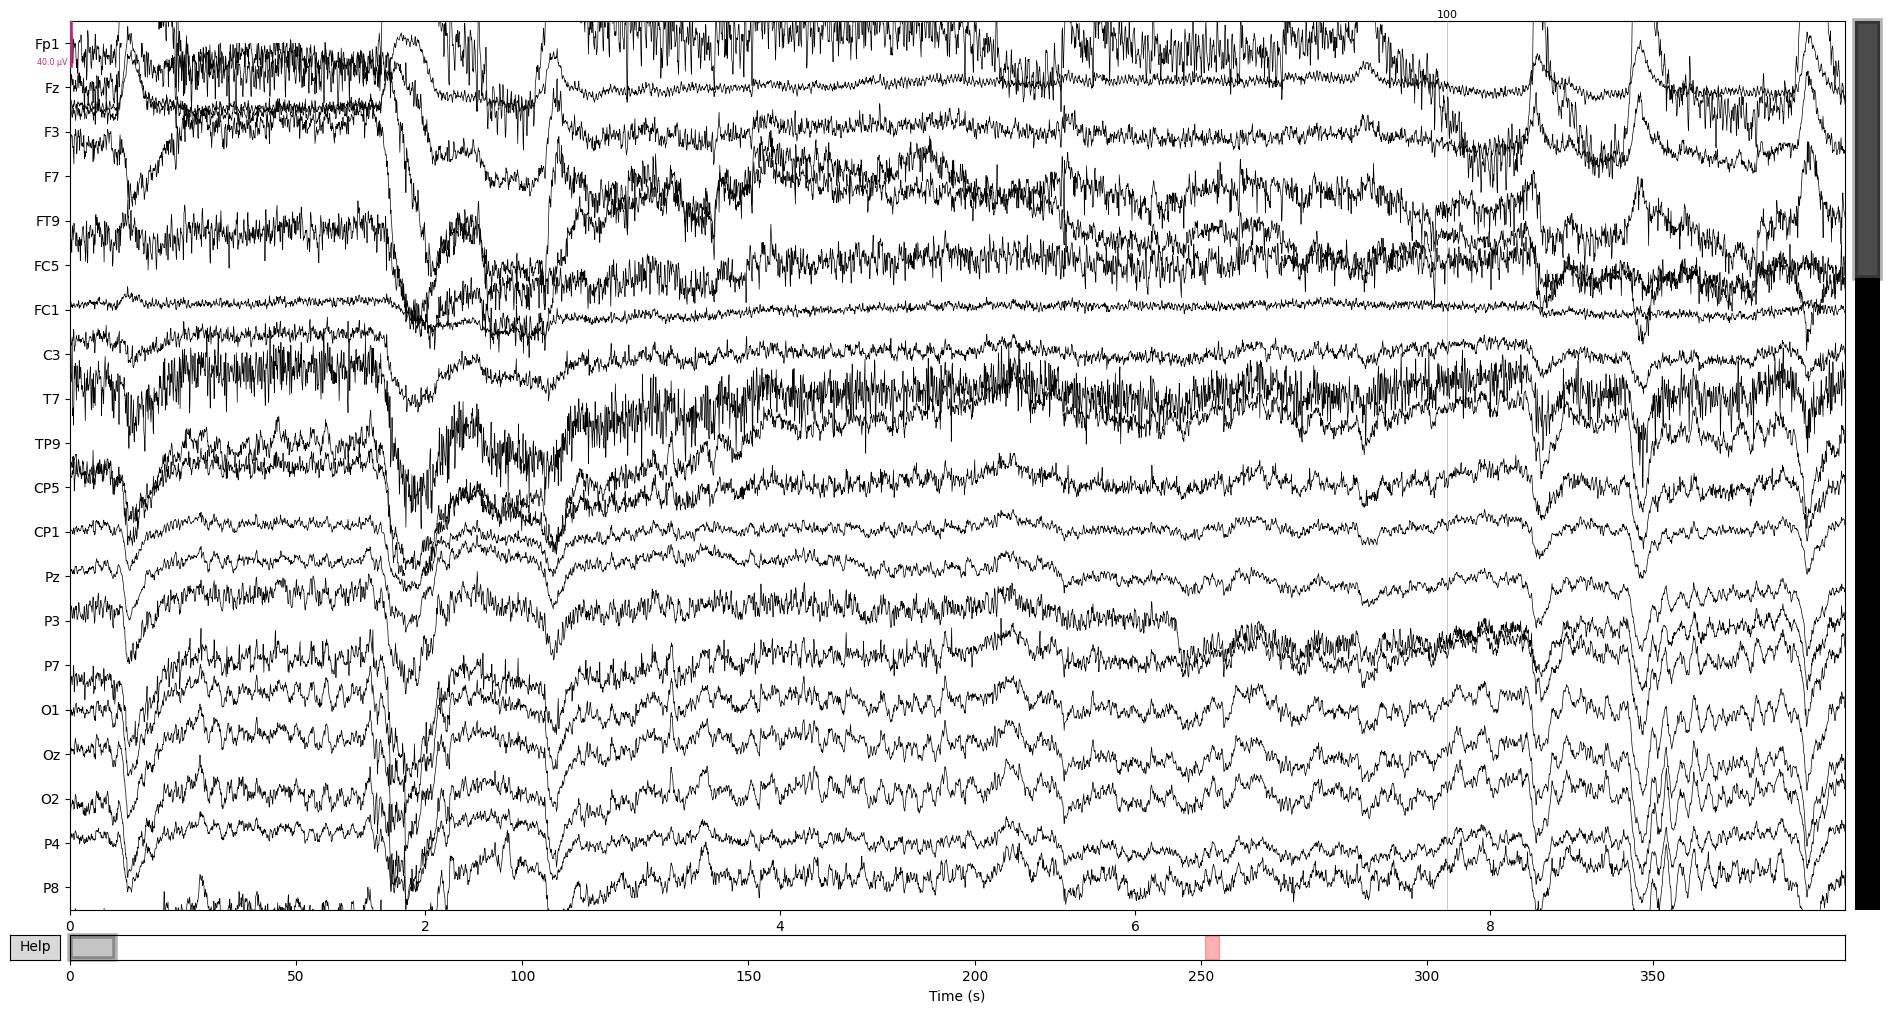

In [21]:
raw.plot(events=events)

**Define timing and events for epoching**

In [23]:
# Timing between start of the trial and onset of bars AND start to end of trial

# 10:	new trial
# 11:	prepare signal (white circle)
# 12:	inter stimulus interval 1
# 13:	go signal (green circle)
# 14:	inter stimulus interval 2
# 15:	KEY PRESS

events_clean = np.vstack(trial_events)
    
starts = events_clean[events_clean[:, 2] == 10][:, 0]
prepare = events_clean[events_clean[:, 2] == 11][:, 0]
go = events_clean[events_clean[:, 2] == 13][:, 0]
key_press = events_clean[events_clean[:, 2] == 15][:, 0]
ends = events_clean[events_clean[:, 2] == 14][:, 0]

n_trials = len(starts)

timing = pd.DataFrame({
    'start_to_end': (ends - starts) / sfreq,
    'start_to_prepare': (prepare - starts) / sfreq,
    'prepare_to_go': (go - prepare) / sfreq,
    'go_to_key_press': (key_press - go) / sfreq,
    'key_press_to_end': (ends - key_press) / sfreq
})
timing.describe()

,start_to_end,start_to_prepare,prepare_to_go,go_to_key_press,key_press_to_end
count,99.000000,99.000000,99.000000,99.000000,99.000000
mean,2.257010,0.010566,1.112424,0.231596,0.902424
std,0.149417,0.003393,0.147804,0.064722,0.001378
min,1.916000,0.004000,0.860000,0.116000,0.900000
25%,2.140000,0.008000,0.981000,0.180000,0.902000
50%,2.260000,0.010000,1.122000,0.232000,0.902000
75%,2.365000,0.012000,1.235000,0.272000,0.902000
max,2.630000,0.026000,1.334000,0.458000,0.908000


**Minimum timing**
- 'start_to_end': 1.9
- 'start_to_prepare': 0 
- 'prepare_to_go': 0.86
- 'go_to_key_press': 0.12
- 'key_press_to_end': 0.9
- ITI: 0.8

**Minimum timing for PREPARE epochs:**
[-0.7 0.85]

**Minimum timing for GO epochs:**
[-0.7 1.5] # Could do more

In [24]:
# Timing of inter-trial intervals (ITI)
intervals = np.append(np.where((starts[1:] - ends[:-1]) / sfreq <= 2,
                                (starts[1:] - ends[:-1]) / sfreq,
                                np.nan),
                      np.nan)
pd.Series(intervals).describe()


count    95.000000
mean      0.810379
std       0.091222
min       0.796000
25%       0.800000
50%       0.802000
75%       0.802000
max       1.690000
dtype: float64

__________________

**Sanity check**

Do any events ofverlap with the epochs except for target ones?

In [ ]:
# PREPARE EPOCHS: check for overlapping events
for event in events_clean:
    if event[2] == 11:  # prepare event
        t0 = event[0]
        tmin = t0 - int(0.7 * sfreq)
        tmax = t0 + int(0.85 * sfreq)

        mask = (events_clean[:, 0] >= tmin) & (events_clean[:, 0] <= tmax) & (events_clean[:, 0] != t0)
        overlapping = events_clean[mask]

        print(f"\nPrepare event at {t0}:")
        print(overlapping)
# ALL GOOD! 10 and 12 are OK


Prepare event at 13852:
[[13847     0    10]]

Prepare event at 15567:
[[15563     0    10]]

Prepare event at 17255:
[[17249     0    10]
 [17661     0    12]]

Prepare event at 18707:
[[18702     0    10]]

Prepare event at 20340:
[[20335     0    10]]

Prepare event at 22908:
[[22903     0    10]
 [23308     0    12]]

Prepare event at 24353:
[[24348     0    10]]

Prepare event at 25821:
[[25817     0    10]]

Prepare event at 27330:
[[27326     0    10]]

Prepare event at 28942:
[[28937     0    10]]

Prepare event at 55128:
[[55122     0    10]
 [55542     0    12]]

Prepare event at 56609:
[[56602     0    10]]

Prepare event at 58229:
[[58224     0    10]]

Prepare event at 59855:
[[59847     0    10]]

Prepare event at 61380:
[[61375     0    10]]

Prepare event at 62978:
[[62974     0    10]
 [63389     0    12]]

Prepare event at 64407:
[[64402     0    10]]

Prepare event at 65875:
[[65870     0    10]]

Prepare event at 67508:
[[67501     0    10]]

Prepare event at 69081

In [ ]:
# GO EPOCHS: check for overlapping events
for event in events_clean:
    if event[2] == 15:  # key press event
        t0 = event[0]
        tmin = t0 - int(0.7 * sfreq)
        tmax = t0 + int(1.5 * sfreq)

        mask = (events_clean[:, 0] >= tmin) & (events_clean[:, 0] <= tmax) & (events_clean[:, 0] != t0)
        overlapping = events_clean[mask]

        print(f"\nKey press event at {t0}:")
        print(overlapping)
# ALL GOOD! 12, 13 and 14 are OK


Prepare event at 14712:
[[14432     0    12]
 [14483     0    13]
 [15162     0    14]]

Prepare event at 16397:
[[16170     0    12]
 [16220     0    13]
 [16849     0    14]]

Prepare event at 17850:
[[17661     0    12]
 [17712     0    13]
 [18301     0    14]]

Prepare event at 19483:
[[19310     0    12]
 [19361     0    13]
 [19934     0    14]]

Prepare event at 21045:
[[20874     0    12]
 [20925     0    13]
 [21498     0    14]]

Prepare event at 23497:
[[23308     0    12]
 [23358     0    13]
 [23948     0    14]]

Prepare event at 24965:
[[24798     0    12]
 [24849     0    13]
 [25416     0    14]]

Prepare event at 26474:
[[26333     0    12]
 [26384     0    13]
 [26925     0    14]]

Prepare event at 28085:
[[27945     0    12]
 [27996     0    13]
 [28537     0    14]]

Prepare event at 29681:
[[29558     0    12]
 [29609     0    13]
 [30132     0    14]]

Prepare event at 55749:
[[55542     0    12]
 [55592     0    13]
 [56201     0    14]]

Prepare event at 573

ALL GOOD!

_____________________________
EPOCHING

In [28]:
events_dict

{np.str_('Stimulus/S 10'): 10,
 np.str_('Stimulus/S 11'): 11,
 np.str_('Stimulus/S 12'): 12,
 np.str_('Stimulus/S 13'): 13,
 np.str_('Stimulus/S 14'): 14,
 np.str_('Stimulus/S 15'): 15,
 np.str_('Stimulus/S100'): 100,
 np.str_('Stimulus/S101'): 101,
 np.str_('Stimulus/S102'): 102,
 np.str_('Stimulus/S103'): 103}

Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 99 events and 776 original time points ...
0 bad epochs dropped


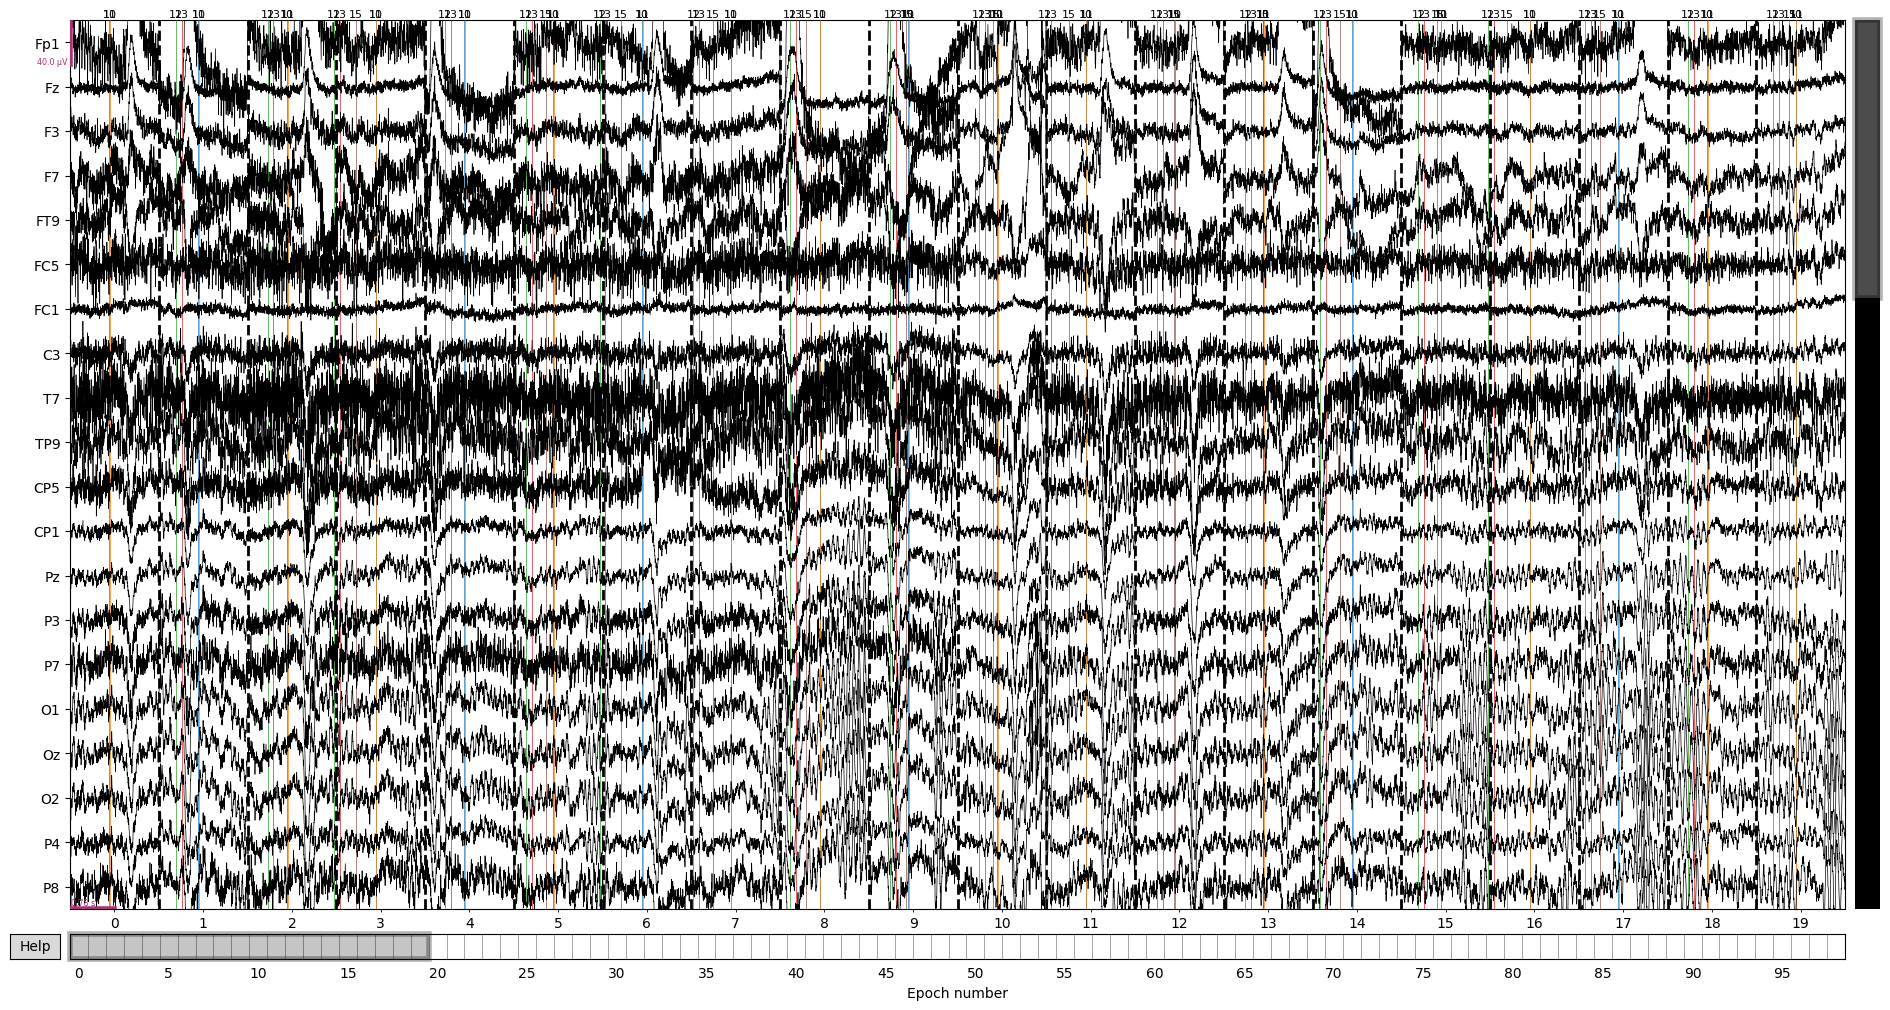

In [29]:
# EPOCHING: PREPARE trials
events_prepare = events_clean[events_clean[:, 2] == 11]

event_id_prepare = { np.str_('Stimulus/S 11'): 11}
epo_tmin_prepare, epo_tmax_prepare = -0.7, 0.85

epochs_prepare = mne.Epochs(
    raw,
    events_prepare,
    event_id=event_id_prepare,
    tmin=epo_tmin_prepare,
    tmax=epo_tmax_prepare,
    baseline=(epo_tmin_prepare, 0),
    reject_by_annotation=True,
    preload=True,
)
epochs_prepare.plot(events=events_clean)


Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 99 events and 1101 original time points ...
0 bad epochs dropped


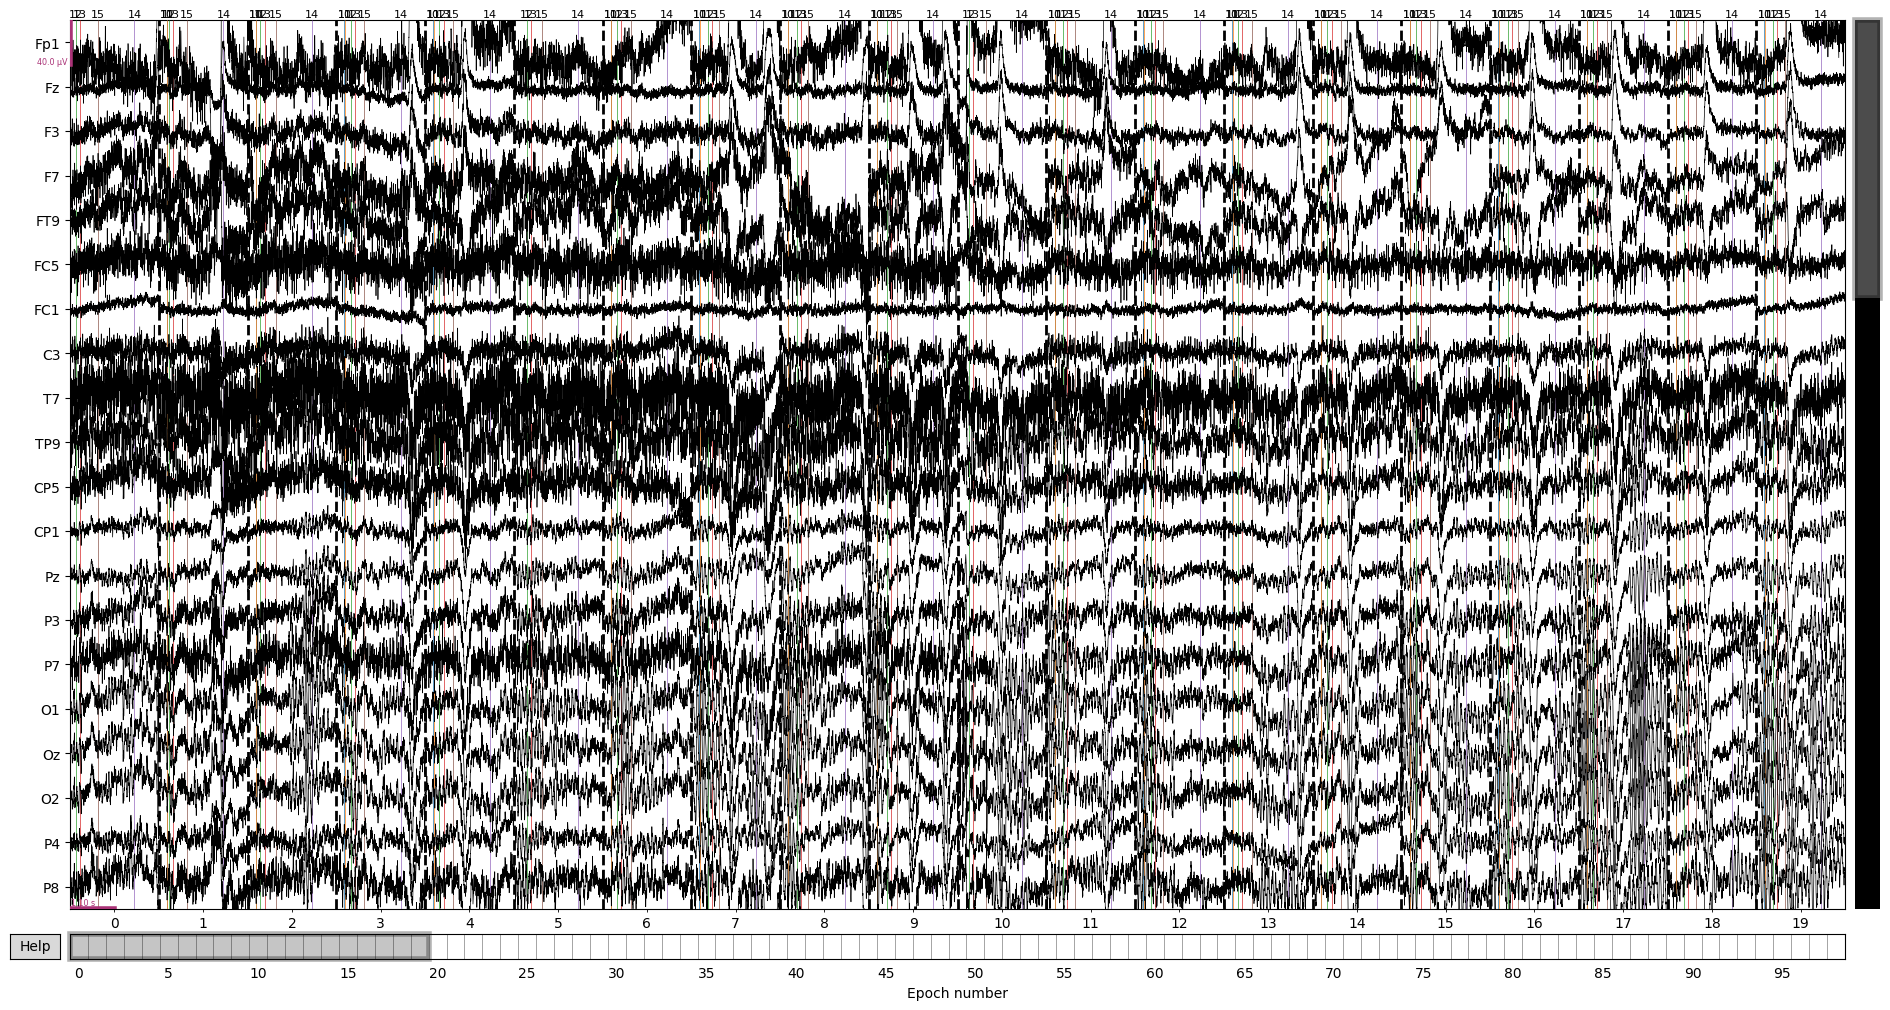

In [31]:
# EPOCHING: GO trials
events_go = events_clean[events_clean[:, 2] == 15]

event_id_go = {np.str_('Stimulus/S 15'): 15}
epo_tmin_go, epo_tmax_go = -0.7, 1.5

epochs_go = mne.Epochs(
    raw,
    events_go,
    event_id=event_id_go,
    tmin=epo_tmin_go,
    tmax=epo_tmax_go,
    baseline=(epo_tmin_go, 0),
    reject_by_annotation=True,
    preload=True,
)
epochs_go.plot(events=events_clean)


In [ ]:
epo_save_path = "D:\\BonoKat\\research project\\# PD project\\data_analysis\\epochs"
np.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_clean_events.npy'), events_clean)
epochs_prepare.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_PREPARE_epochs.fif'), overwrite=True)
epochs_go.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_GO_epochs.fif'), overwrite=True)

C:\Users\a1902989\AppData\Local\Temp\ipykernel_15988\3022328471.py:3: RuntimeWarning: This filename (D:\BonoKat\research project\# PD project\data_analysis\ARI\epochs\PDc_s1_sub00_GR_FTT_PREPARE_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_prepare.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_PREPARE_epochs.fif'), overwrite=True)
C:\Users\a1902989\AppData\Local\Temp\ipykernel_15988\3022328471.py:4: RuntimeWarning: This filename (D:\BonoKat\research project\# PD project\data_analysis\ARI\epochs\PDc_s1_sub00_GR_FTT_GO_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_go.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_GO_epochs.fif'), overwrite=True)


[WindowsPath('D:/BonoKat/research project/# PD project/data_analysis/ARI/epochs/PDc_s1_sub00_GR_FTT_GO_epochs.fif')]